In [1]:
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import numpy as np
from pyuvdata import UVCal, UVData
import os
import sys
import glob
import uvtools as uvt
from astropy.time import Time
from astropy.coordinates import EarthLocation, AltAz, Angle
from astropy.coordinates import SkyCoord as sc
import pandas
import warnings 
import copy
from hera_notebook_templates import utils
import hera_qm
from hera_mc import cm_hookup
import h5py
import importlib
from scipy import stats
from matplotlib import colors
#warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


In [2]:
def calcEvenOddAmpMatrix(sm,df,pols=['xx','yy'],nodes='auto', badThresh=0.25, plotRatios=False, 
                        avg = 'coherent'):
    """
    Calculates a matrix of phase correlations between antennas, where each pixel is calculated as (even/abs(even)) * (conj(odd)/abs(odd)), and then averaged across time and frequency.
    
    Paramters:
    ---------
    sm: UVData Object
        Sum observation.
    df: UVData Object
        Diff observation. Must be the same time of observation as sm. 
    pols: List
        Polarizations to plot. Can include any polarization strings accepted by pyuvdata.
    nodes: String or List
        Nodes to include in matrix. Default is 'auto', which generates a list of all nodes included in the provided data files. 
    badThresh: Float
        Threshold correlation metric value to use for flagging bad antennas.
    
    Returns:
    -------
    data: Dict
        Dictionary containing calculated values, formatted as data[polarization][ant1,ant2]. 
    badAnts: List
        List of antennas that were flagged as bad based on badThresh.
    """
    if sm.time_array[0] != df.time_array[0]:
        print('FATAL ERROR: Sum and diff files are not from the same observation!')
        return None
    if nodes=='auto':
        nodeDict, antDict, inclNodes = utils.generate_nodeDict(sm)
    nants = len(sm.get_ants())
    data = {}
    antnumsAll = utils.sort_antennas(sm)
    badAnts = []
    for p in range(len(pols)):
        pol = pols[p]
        data[pol] = np.empty((nants,nants))
        for i in range(len(antnumsAll)):
            thisAnt = []
            for j in range(len(antnumsAll)):
                ant1 = antnumsAll[i]
                ant2 = antnumsAll[j]
                s = sm.get_data(ant1,ant2,pol)
                d = df.get_data(ant1,ant2,pol)
                even = (s + d)/2
                even = np.divide(even,np.abs(even))
                odd = (s - d)/2
                odd = np.divide(odd,np.abs(odd))
                product = np.multiply(even,np.conj(odd))
                if avg=='coherent':
                    data[pol][i,j] = np.abs(np.nanmean(product))
                    thisAnt.append(np.abs(np.nanmean(product)))
                elif avg=='incoherent':
                    data[pol][i,j] = np.nanmean(np.abs(product))
                    thisAnt.append(np.nanmean(np.abs(product)))
                elif avg=='complex':
                    data[pol][i,j] = np.nanmean(product)
                    thisAnt.append(np.nanmean(product))
#                 else:
#                     print('ERROR: avg must be either coherent or incoherent')
#             pgood = np.count_nonzero(~np.isnan(thisAnt))/len(thisAnt)
#             if (np.nanmedian(thisAnt) < badThresh or pgood<0.2) and antnumsAll[i] not in badAnts:
#                 if pol[0]==pol[1]:
#                     #Don't assign bad ants based on cross pols
#                     badAnts.append(antnumsAll[i])
    if plotRatios is True:
        if len(pols) == 4:
            data['xx-xy'] = np.subtract(data['xx'],data['xy'])
            data['xx-yx'] = np.subtract(data['xx'],data['yx'])
            data['yy-xy'] = np.subtract(data['yy'],data['xy'])
            data['yy-yx'] = np.subtract(data['yy'],data['yx'])
        else:
            print('Can only calculate differences if cross pols were specified')
        polAnts = {}
        badAnts = []
        subs = ['xx-xy','xx-yx','yy-xy','yy-yx']
        for k in subs:
            for i,ant in enumerate(antnumsAll):
                dat = data[k][i,:]
                if np.nanmedian(dat) < 0:
                    if ant in polAnts.keys():
                        polAnts[ant] = polAnts[ant] + 1
                    else:
                        polAnts[ant] = 1
                    if polAnts[ant] == 4:
                        badAnts.append(ant)  
    return data, badAnts, antnumsAll

In [3]:
def plotCorrMatrix(uv,data,pols=['xx','yy'],vminIn=0,vmaxIn=1,nodes='auto',logScale=False,plotRatios=False,
                  savefig=False,title=''):
    """
    Plots a matrix representing the phase correlation of each baseline.
    
    Parameters:
    ----------
    uv: UVData Object
        Observation used for calculating the correlation metric
    data: Dict
        Dictionary containing the correlation metric for each baseline and each polarization. Formatted as data[polarization]  [ant1,ant2] 
    pols: List
        Polarizations to plot. Can include any polarization strings accepted by pyuvdata.
    vminIn: float
        Lower limit of colorbar. Default is 0.
    vmaxIn: float
        Upper limit of colorbar. Default is 1.
    nodes: Dict
        Dictionary containing the nodes (and their constituent antennas) to include in the matrix. Formatted as nodes[Node #][Ant List, Snap # List, Snap Location List].
    logScale: Bool
        Option to put colormap on a logarithmic scale. Default is False.
    """
    if nodes=='auto':
        nodeDict, antDict, inclNodes = utils.generate_nodeDict(uv)
    nantsTotal = len(uv.get_ants())
    power = np.empty((nantsTotal,nantsTotal))
    fig, axs = plt.subplots(2,2,figsize=(16,16))
    dirs = ['NN','EE','NE','EN']
    cmap='plasma'
    if plotRatios is True:
        pols = ['xx-xy','yy-xy','xx-yx','yy-yx']
        dirs=pols
        vminIn=-1
        cmap='seismic'
    loc = EarthLocation.from_geocentric(*uv.telescope_location, unit='m')
    jd = uv.time_array[0]
    t = Time(jd,format='jd',location=loc)
    lst = round(t.sidereal_time('mean').hour,2)
    t.format='fits'
    antnumsAll = utils.sort_antennas(uv)
    i = 0
    for p in range(len(pols)):
        if p >= 2:
            i=1
        pol = pols[p]
        nants = len(antnumsAll)
        if logScale is True:
            im = axs[i][p%2].imshow(data[pol],cmap=cmap,origin='upper',extent=[0.5,nantsTotal+.5,0.5,nantsTotal+0.5],norm=colors.LogNorm(vmin=vminIn, vmax=vmaxIn))
        else:
            im = axs[i][p%2].imshow(data[pol],cmap=cmap,origin='upper',extent=[0.5,nantsTotal+.5,0.5,nantsTotal+0.5],vmin=vminIn, vmax=vmaxIn)
        axs[i][p%2].set_xticks(np.arange(0,nantsTotal)+1)
        axs[i][p%2].set_xticklabels(antnumsAll,rotation=90,fontsize=6)
        axs[i][p%2].xaxis.set_ticks_position('top')
        axs[i][p%2].set_title('polarization: ' + dirs[p] + '\n')
        n=0
        for node in sorted(inclNodes):
            n += len(nodeDict[node]['ants'])
            axs[i][p%2].axhline(len(antnumsAll)-n+.5,lw=4)
            axs[i][p%2].axvline(n+.5,lw=4)
            axs[i][p%2].text(n-len(nodeDict[node]['ants'])/2,-.5,node)
        axs[i][p%2].text(.42,-.05,'Node Number',transform=axs[i][p%2].transAxes)
    n=0
    for node in sorted(inclNodes):
        n += len(nodeDict[node]['ants'])
        axs[0][1].text(nantsTotal+1,nantsTotal-n+len(nodeDict[node]['ants'])/2,node)
        axs[1][1].text(nantsTotal+1,nantsTotal-n+len(nodeDict[node]['ants'])/2,node)
    axs[0][1].text(1.05,0.4,'Node Number',rotation=270,transform=axs[0][1].transAxes)
    axs[0][1].set_yticklabels([])
    axs[0][1].set_yticks([])
    axs[0][0].set_yticks(np.arange(nantsTotal,0,-1))
    axs[0][0].set_yticklabels(antnumsAll,fontsize=6)
    axs[0][0].set_ylabel('Antenna Number')
    axs[1][1].text(1.05,0.4,'Node Number',rotation=270,transform=axs[1][1].transAxes)
    axs[1][1].set_yticklabels([])
    axs[1][1].set_yticks([])
    axs[1][0].set_yticks(np.arange(nantsTotal,0,-1))
    axs[1][0].set_yticklabels(antnumsAll,fontsize=6)
    axs[1][0].set_ylabel('Antenna Number')
    cbar_ax = fig.add_axes([0.98,0.18,0.015,0.6])
    cbar_ax.set_xlabel('|V|', rotation=0)
    cbar = fig.colorbar(im, cax=cbar_ax)
    fig.suptitle('Correlation Matrix - JD: %s, LST: %.0fh' % (str(jd),np.round(lst,0)))
    fig.subplots_adjust(top=1.28,wspace=0.05,hspace=1.1)
    fig.tight_layout(pad=2)
    if savefig:
        plt.savefig(f'{title}.pdf')
    plt.show()
    plt.close()

In [4]:
lower=50
upper=410
interval=10
pols=['xx','yy','xy','yx']

In [5]:
#get data location
data_path = '/lustre/aoc/projects/hera/H4C/2459139'
ant_metrics_ext = ".known_good.ant_metrics.hdf5"
statuses = 'RF_ok,digital_ok,digital_maintenance,calibration_ok,RF_maintenance'
JD = 2459139
utc = Time(JD, format='jd').datetime
print(f'JD = {JD}')
print(f'Date = {utc.month}-{utc.day}-{utc.year}')
print(f'data_path = "{data_path}"')

JD = 2459139
Date = 10-16-2020
data_path = "/lustre/aoc/projects/hera/H4C/2459139"


In [6]:
# Load in data
HHfiles, difffiles, HHautos, diffautos, uvdx, uvdy = utils.load_data(data_path,JD)
    
uvd = UVData()
unread = True
readInd=0
while unread and readInd<len(HHautos):
    try:
        uvd.read(HHautos[readInd])
        unread = False
    except:
        readInd += 1
        continue
use_ants = utils.get_use_ants(uvd,statuses,JD)
print(f'This day contains {len(use_ants)} antennas of the given status category.')
j=0
all_data = {}
for i in range(lower,upper,interval):
    print(i)
    print('Reading sum files')
    uvd = UVData()
    uvd.read(HHfiles[i:i+interval], skip_bad_files=True, antenna_nums = use_ants)
    print('Reading diff files')
    uvd_diff = UVData()
    uvd_diff.read(difffiles[i:i+interval], skip_bad_files=True, antenna_nums = use_ants)
    data, badAnts, antnumsAll = calcEvenOddAmpMatrix(uvd,uvd_diff,pols=pols,avg='complex')
    del uvd
    del uvd_diff
    for p in pols:
        if j==0:
            all_data[p] = np.zeros((data[p].shape[0],data[p].shape[1],(upper-lower)//interval))
        all_data[p][:,:,j] = data[p]  
    j += 1

1862 sum files found between JDs 2459139.25108 and 2459139.66738
1862 diff files found between JDs 2459139.25108 and 2459139.66738
1862 sum auto files found between JDs 2459139.25108 and 2459139.66738
1862 diff auto files found between JDs 2459139.25108 and 2459139.66738
This day contains 103 antennas of the given status category.
50
Reading sum files
Reading diff files
60
Reading sum files
Reading diff files
70
Reading sum files
Reading diff files
80
Reading sum files
Reading diff files
90
Reading sum files
Reading diff files
100
Reading sum files
Reading diff files
110
Reading sum files
Reading diff files
120
Reading sum files
Reading diff files
130
Reading sum files
Reading diff files
140
Reading sum files
Reading diff files
150
Reading sum files
Reading diff files
160
Reading sum files
Reading diff files
170
Reading sum files
Reading diff files
180
Reading sum files
Reading diff files
190
Reading sum files
Reading diff files
200
Reading sum files
Reading diff files
210
Reading sum 

In [9]:
uvd = UVData()
unread = True
readInd=0
while unread and readInd<len(HHautos):
    try:
        uvd.read(HHautos[readInd])
        unread = False
    except:
        readInd += 1
        continue

In [7]:
data = {p: np.abs(np.nanmean(all_data[p],axis=2)) for p in pols}

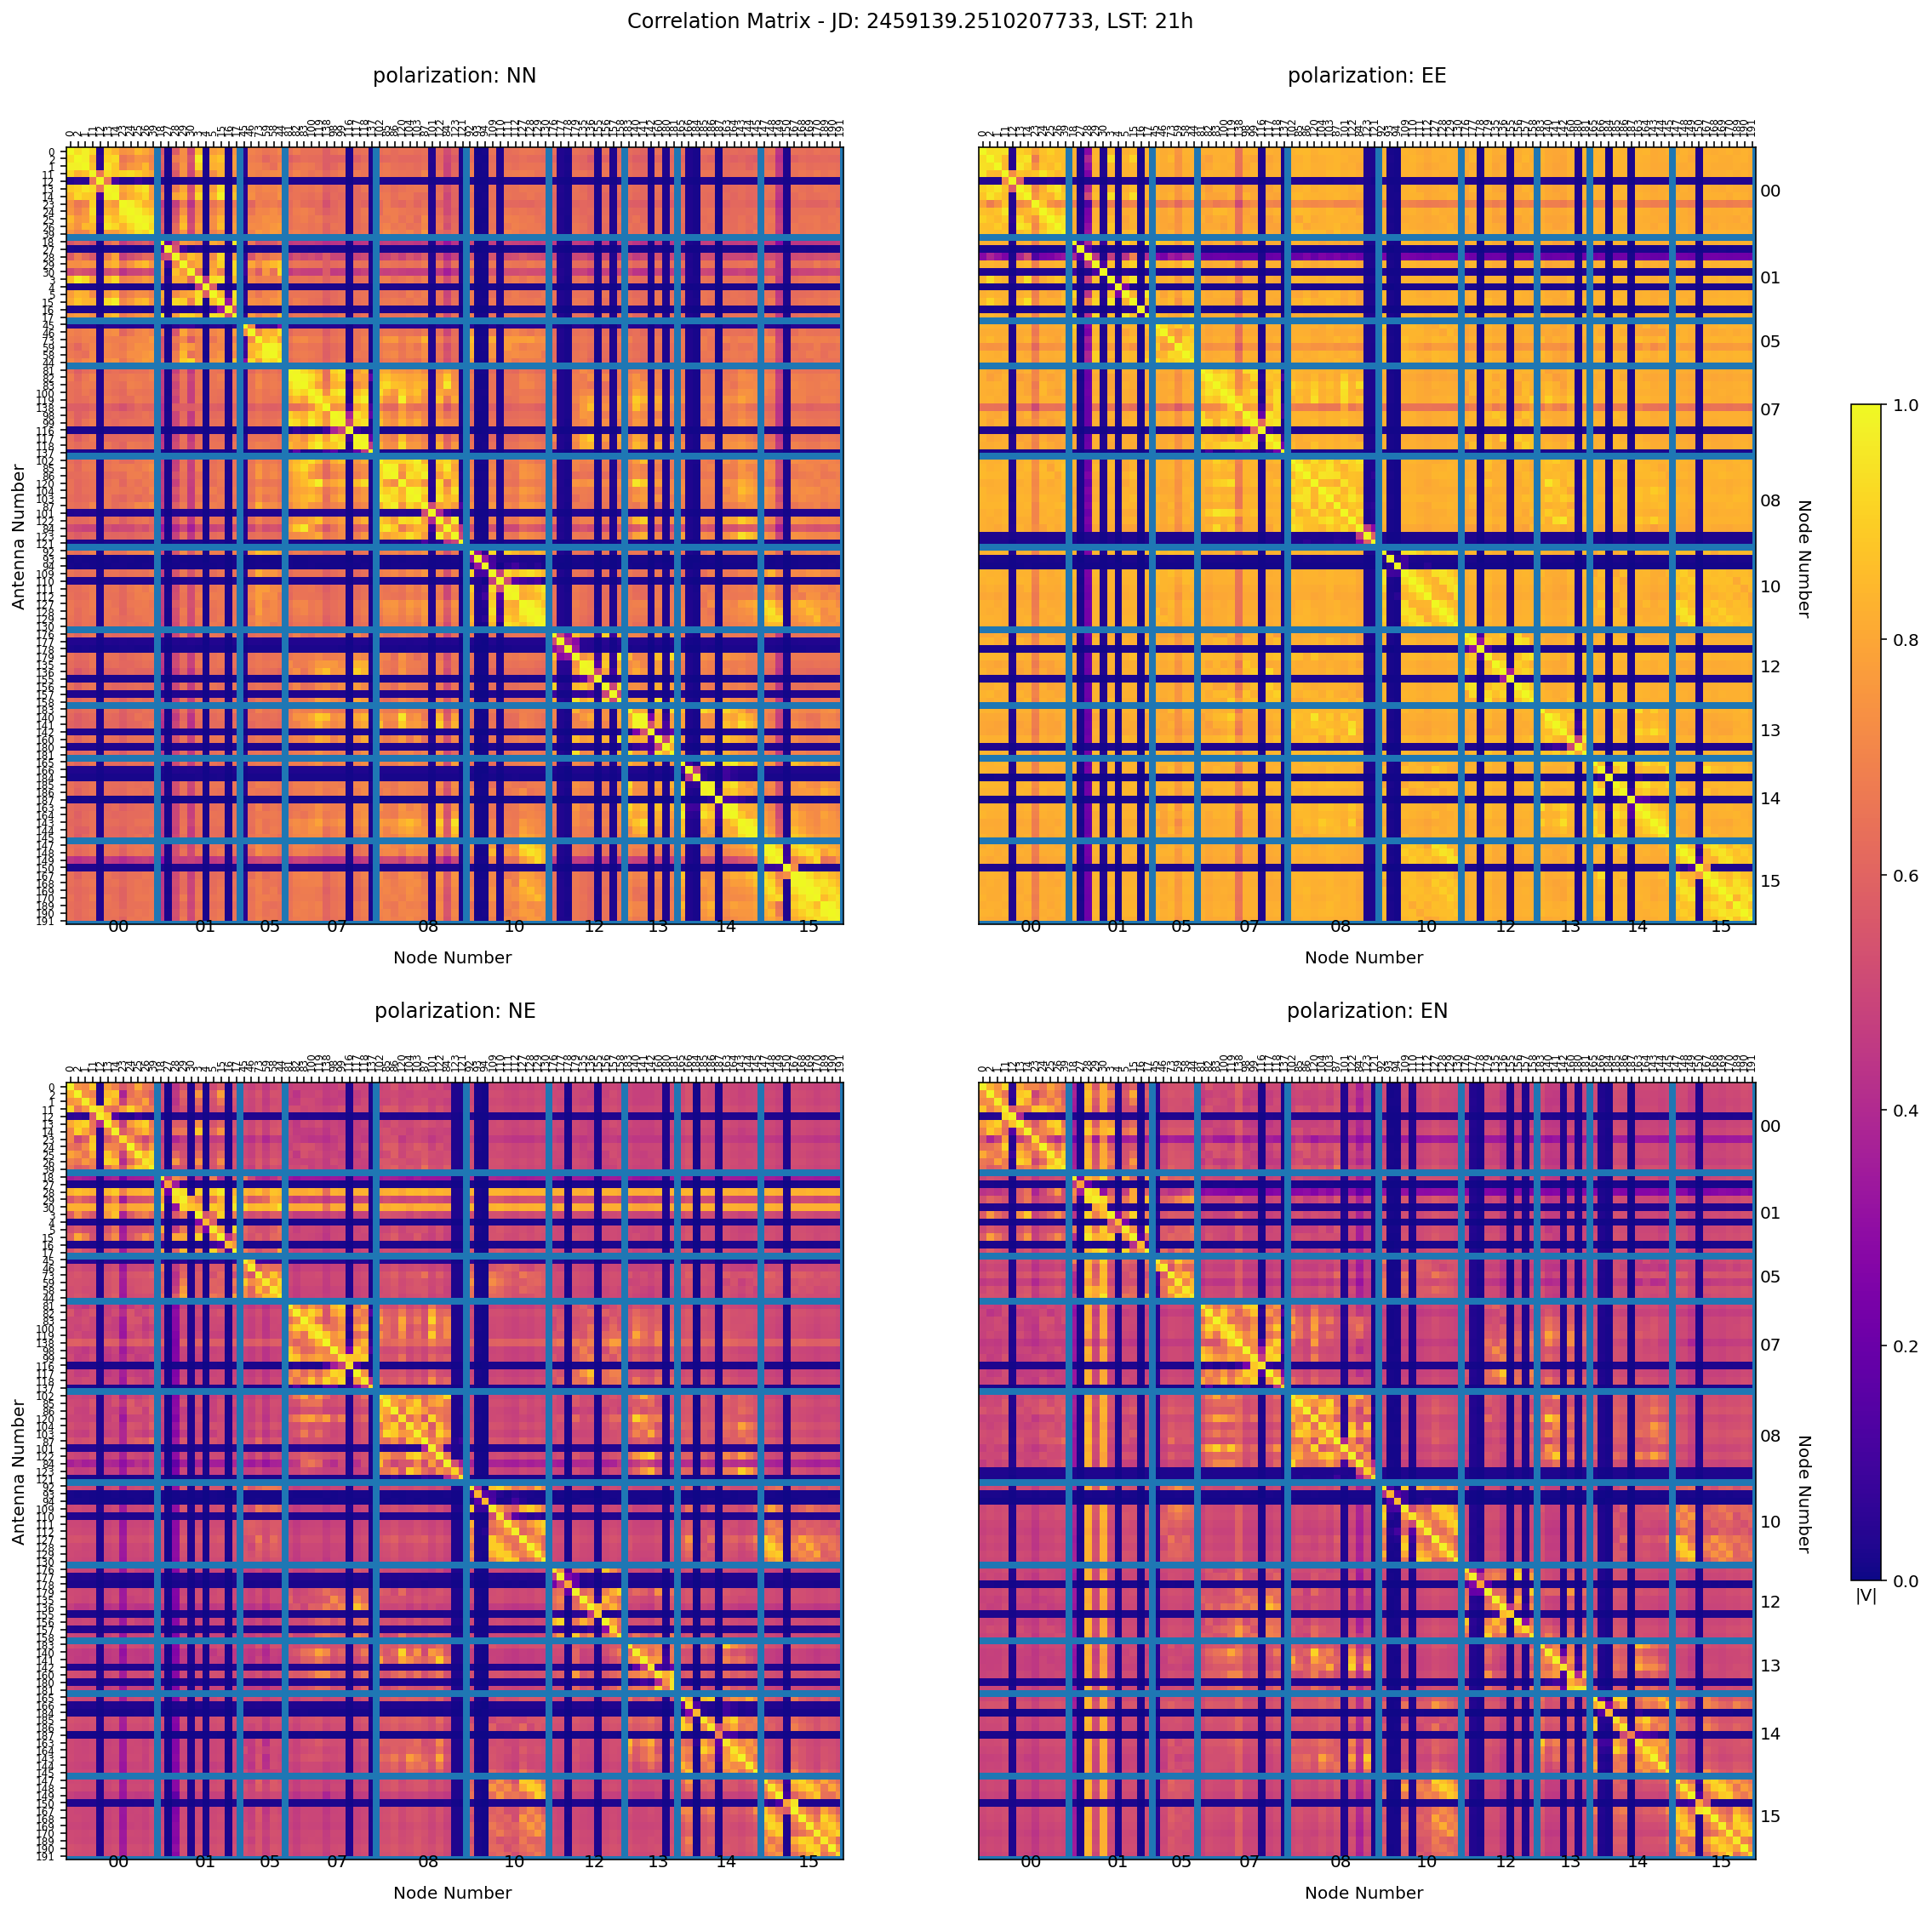

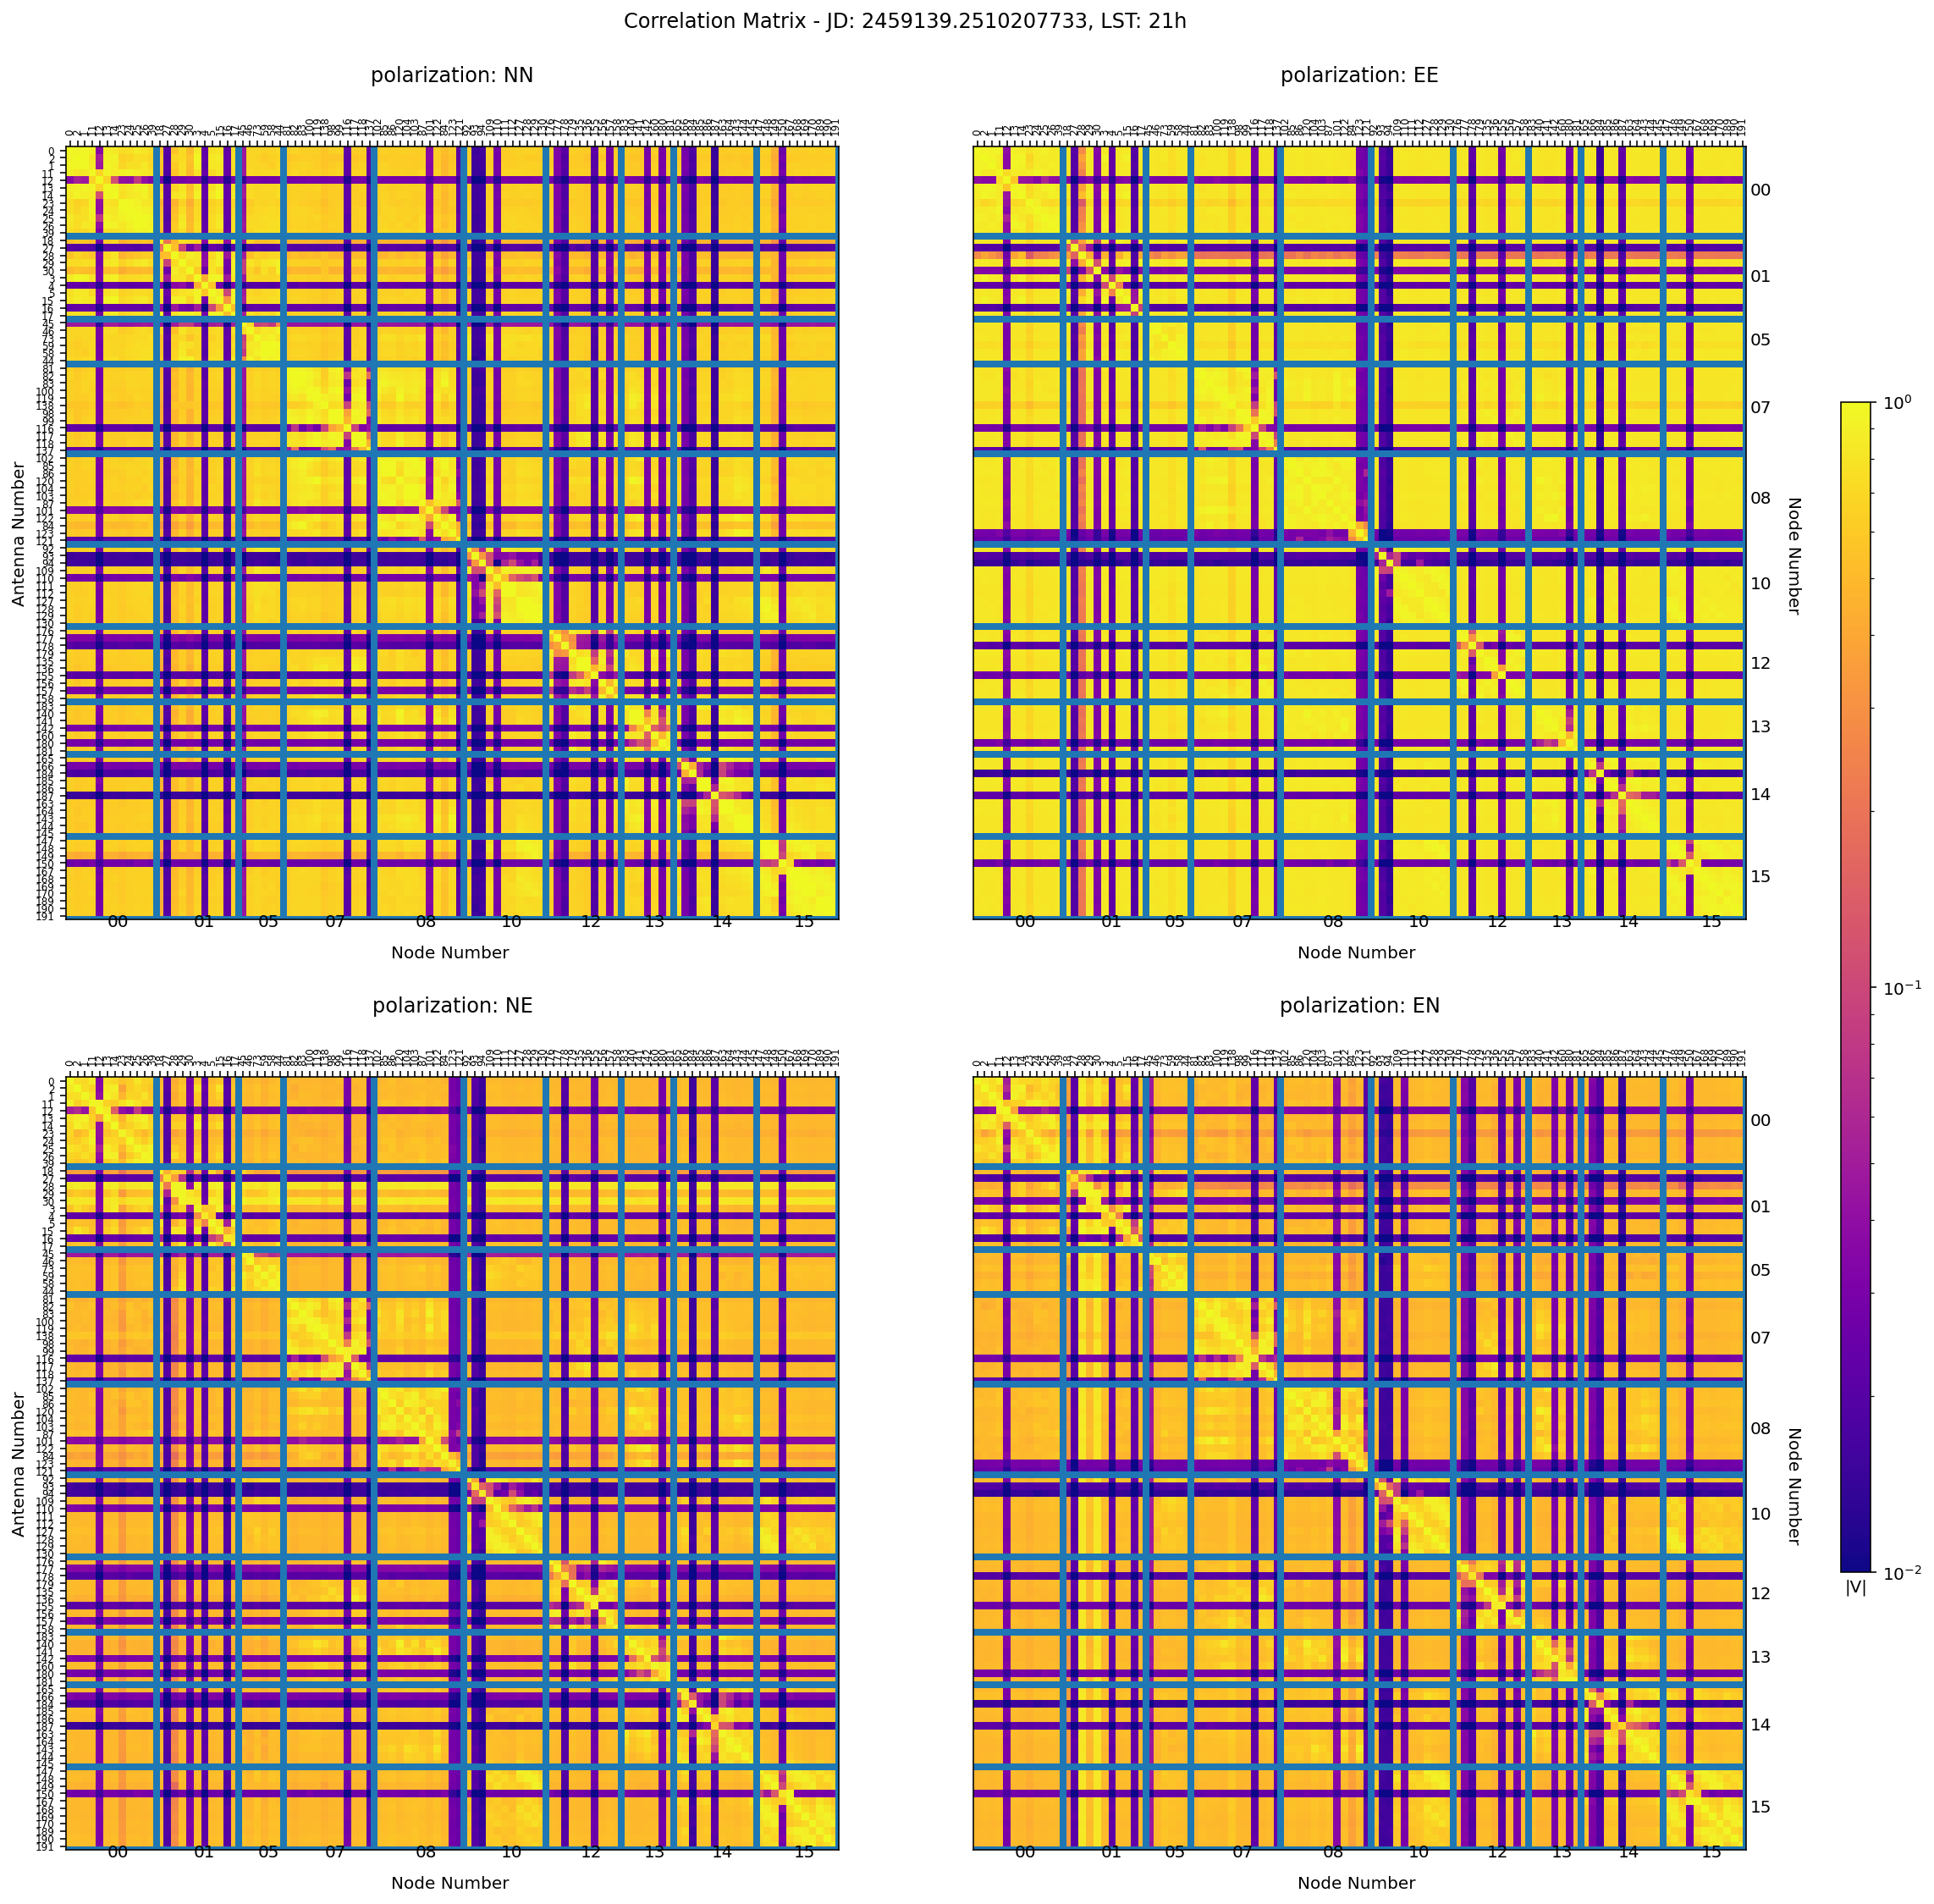

In [10]:
plotCorrMatrix(uvd,data,pols=['xx','yy','xy','yx'],savefig=True,
              title='139_skyData_2hrs_corrMatrix')
plotCorrMatrix(uvd,data,pols=['xx','yy','xy','yx'],savefig=True,logScale=True,vminIn=0.01,
              title='139_skyData_2hrs_corrMatrix_logColorScale')

In [11]:
#get data location
data_path = '/lustre/aoc/projects/hera/lberkhou/2459144'
ant_metrics_ext = ".known_good.ant_metrics.hdf5"
statuses = 'RF_ok,digital_ok,digital_maintenance,calibration_ok,RF_maintenance'
JD = 2459144
utc = Time(JD, format='jd').datetime
print(f'JD = {JD}')
print(f'Date = {utc.month}-{utc.day}-{utc.year}')
print(f'data_path = "{data_path}"')

JD = 2459144
Date = 10-21-2020
data_path = "/lustre/aoc/projects/hera/lberkhou/2459144"


In [12]:
# Load in data
HHfiles, difffiles, HHautos, diffautos, uvdx, uvdy = utils.load_data(data_path,JD)
    
uvd = UVData()
unread = True
readInd=0
while unread and readInd<len(HHautos):
    try:
        uvd.read(HHautos[readInd])
        unread = False
    except:
        readInd += 1
        continue
use_ants = utils.get_use_ants(uvd,statuses,JD)
print(f'This day contains {len(use_ants)} antennas of the given status category.')
j=0
all_data = {}
for i in range(lower,upper,interval):
    print('Reading sum files')
    uvd = UVData()
    uvd.read(HHfiles[i:i+interval], skip_bad_files=True, antenna_nums = use_ants)
    print('Reading diff files')
    uvd_diff = UVData()
    uvd_diff.read(difffiles[i:i+interval], skip_bad_files=True, antenna_nums = use_ants)
    data, badAnts, antnumsAll = calcEvenOddAmpMatrix(uvd,uvd_diff,pols=pols,avg='complex')
    for p in pols:
        if j==0:
            all_data[p] = np.zeros((data[p].shape[0],data[p].shape[1],(upper-lower)//interval))
        all_data[p][:,:,j] = data[p]  
    j += 1
lsts = uvd.lst_array

1862 sum files found between JDs 2459144.25108 and 2459144.66738
1862 diff files found between JDs 2459144.25108 and 2459144.66738
1862 sum auto files found between JDs 2459144.25108 and 2459144.66738
1862 diff auto files found between JDs 2459144.25108 and 2459144.66738
This day contains 71 antennas of the given status category.
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Reading diff files
Reading sum files
Rea

In [13]:
data = {p: np.abs(np.nanmean(all_data[p],axis=2)) for p in pols}

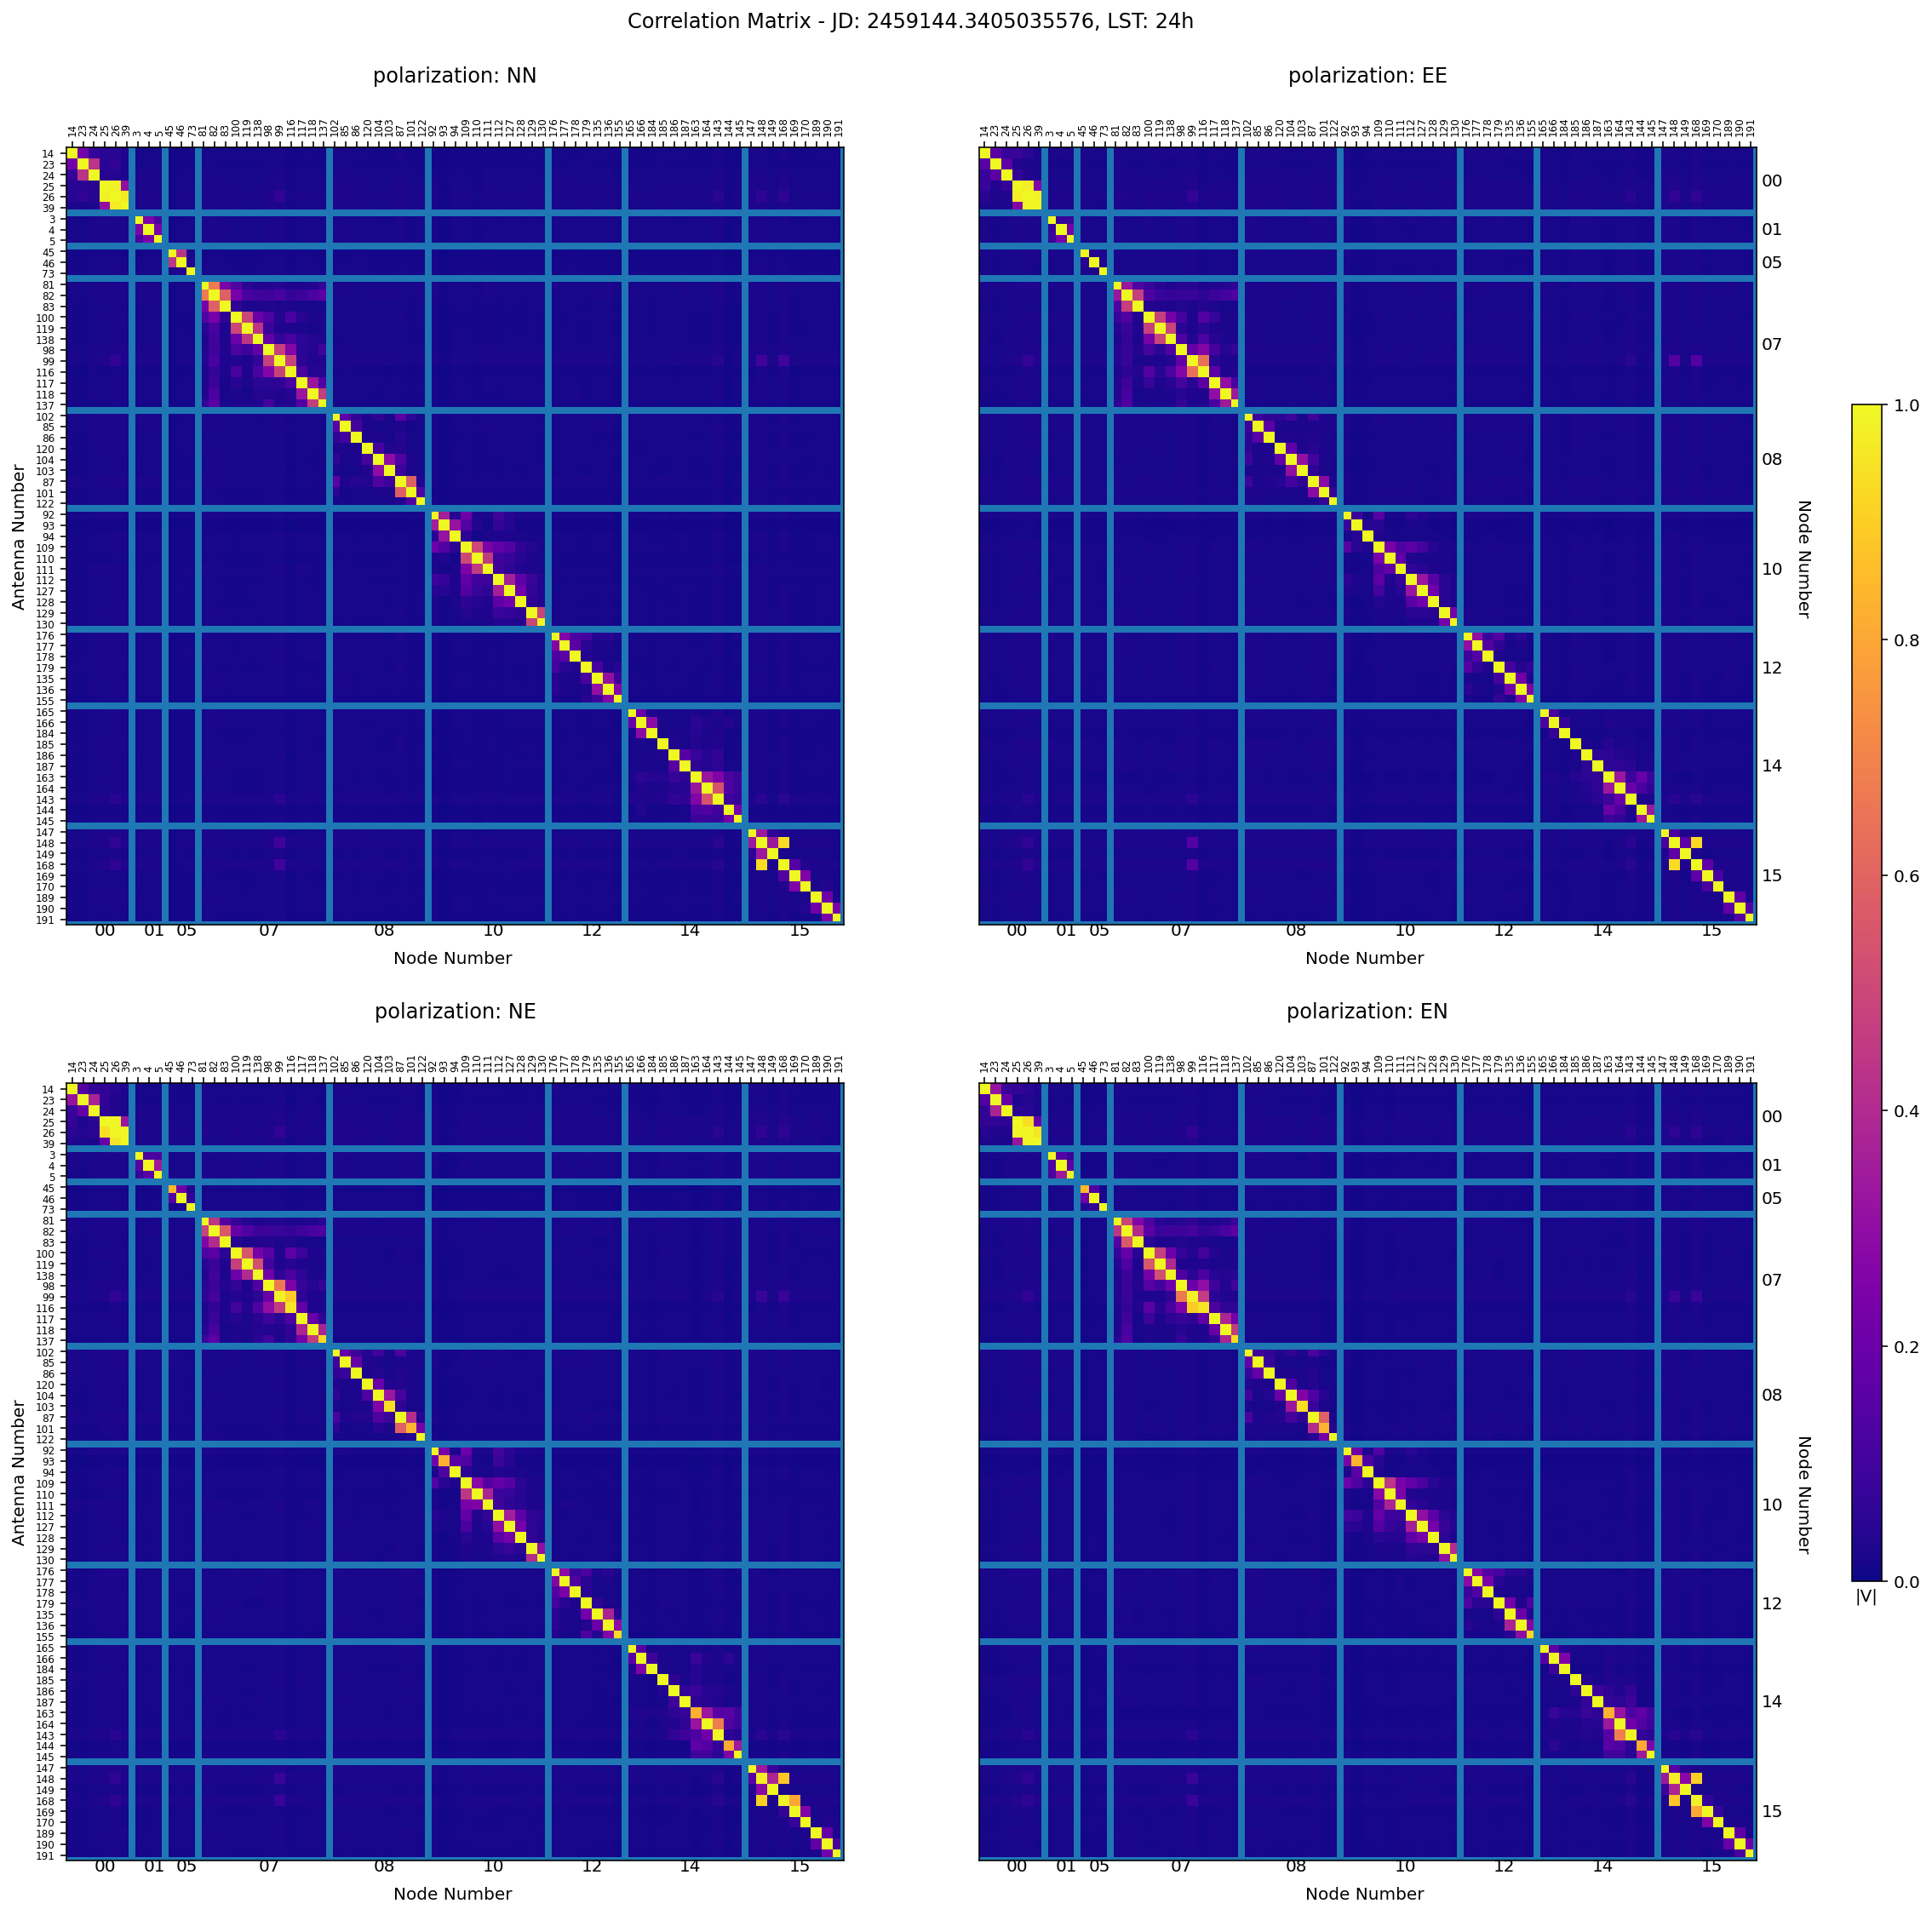

In [14]:
plotCorrMatrix(uvd,data,pols=['xx','yy','xy','yx'],savefig=True,
              title='144_loadData_2hrs_corrMatrix')

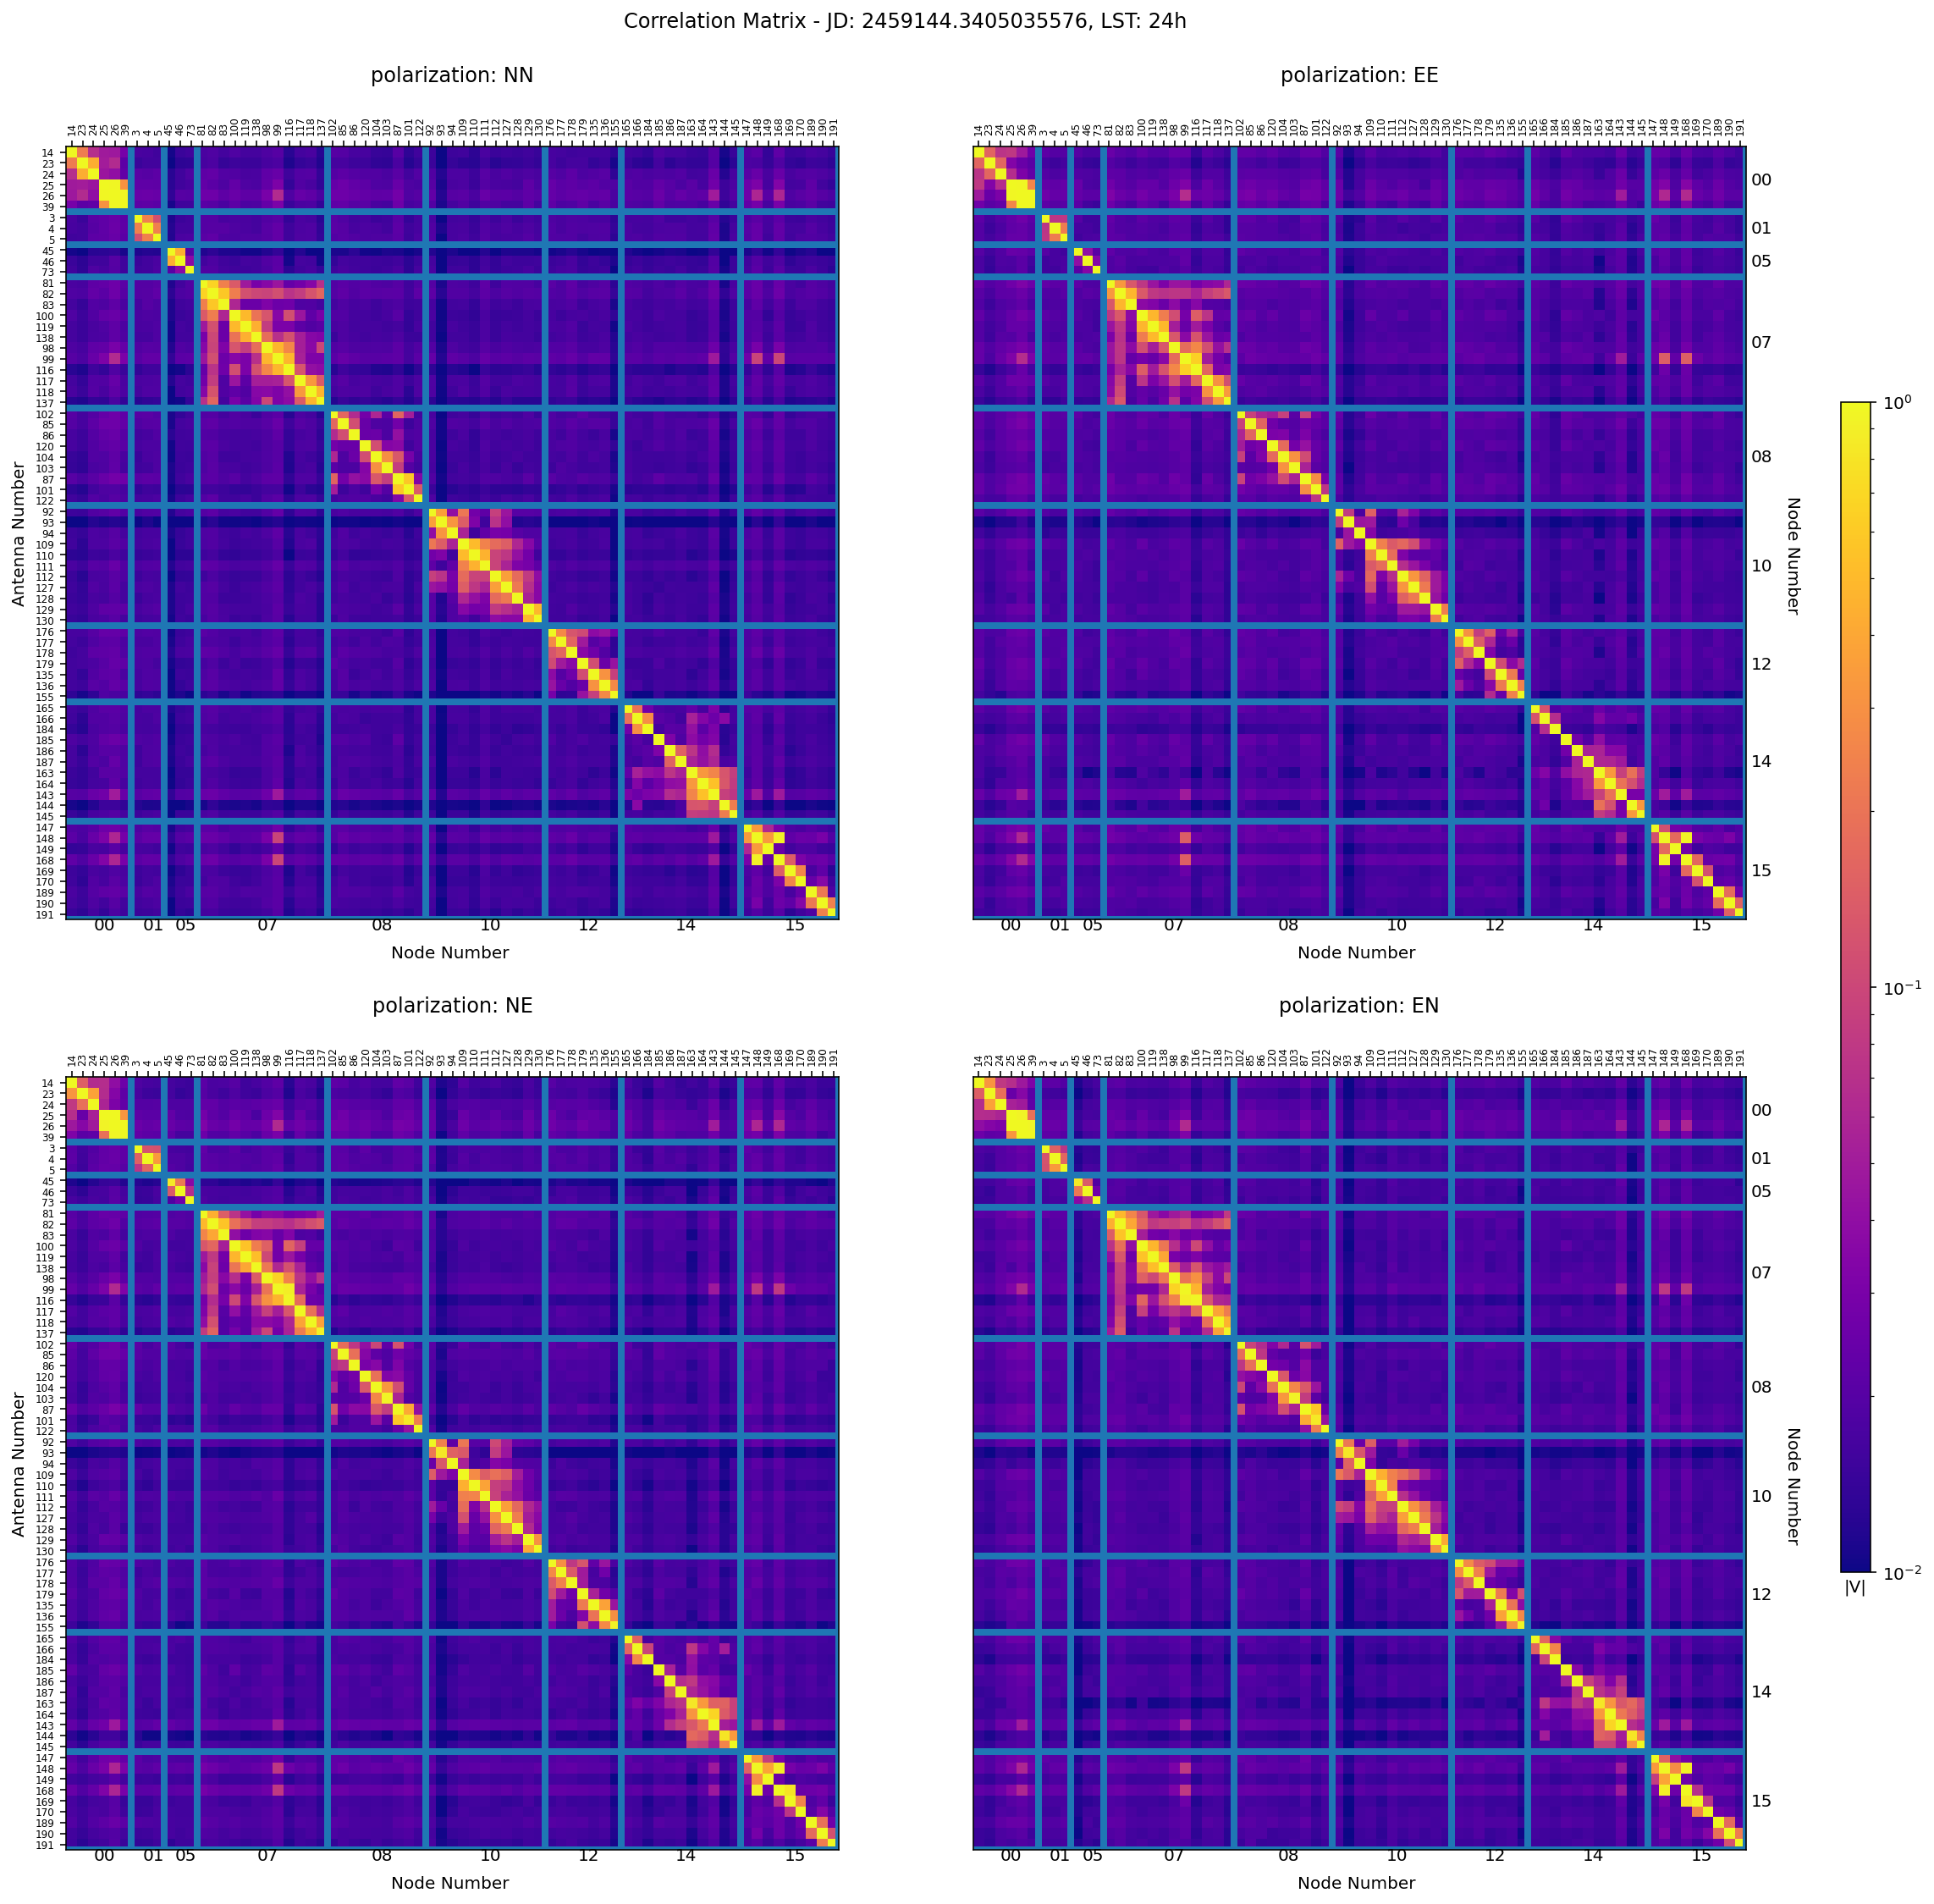

In [15]:
plotCorrMatrix(uvd,data,pols=['xx','yy','xy','yx'],logScale=True,vminIn=0.01,savefig=True,
              title='144_loadData_2hrs_corrMatrix_logColorScale')